# **Livrable 2 – Modélisation du Time-Dependent Vehicle Routing Problem (TDVRP)** 
### Projet ADEME – Mobilité Multimodale Intelligente  
**Équipe :** CesiCDP – Groupe de Louka, Evan, Mael, Hugo  
**Date :** Octobre 2025  
---



## 1. Introduction et Contexte

Depuis les années 90, il y a eu une prise de conscience mondiale de la nécessité de réduire la consommation d'énergie et les émissions de gaz à effet de serre. Les premiers engagements sont apparus lors du **Protocole de Kyoto (1997)**, suivi d'autres plus ambitieux comme la **division par 4 des émissions d’ici 2050 en France**.  

Dans ce contexte, **l’ADEME (Agence de l’Environnement et de la Maîtrise de l’Énergie)** a lancé un appel à manifestation d’intérêt pour promouvoir des **solutions de mobilité innovantes** et plus écologiques.  

Notre équipe **CesiCDP** s’inscrit dans cette démarche à travers une étude sur la **mobilité multimodale intelligente**. Nous avons choisi de nous concentrer sur l’**optimisation des tournées de livraison**, un enjeu central de la logistique moderne.  

Nous modélisons ici un problème de **gestion de tournées (Vehicle Routing Problem - VRP)** en intégrant une **contrainte de trafic dynamique**, pour mieux représenter les conditions de circulation réelles. Notre flotte de véhicules est **thermique et homogène**, ce qui accentue l’importance de la réduction du temps de trajet et de la consommation de carburant.


## 2. Choix de la Méthode : Le Recuit Simulé (SA)

Pour résoudre ce problème, nous avons choisi une **métaheuristique : l'Algorithme du Recuit Simulé (Simulated Annealing)**.

Ce choix est motivé par la nature du problème :

1.  **Problème NP-difficile :** Le VRP (et à plus forte raison le TDVRP) est un problème "NP-difficile". Il est **informatiquement impossible de trouver la solution optimale garantie** en un temps raisonnable pour une instance de 200 clients. Nous devons donc nous tourner vers des méthodes d'approximation.
2.  **Évitement des Minimums Locaux :** Une heuristique simple (comme une "descente") améliorerait la solution en n'acceptant que les "voisins" (solutions légèrement modifiées) qui sont meilleurs. Elle se retrouverait cependant très vite "coincée" dans un **minimum local** : une solution qui *semble* bonne, mais qui n'est pas la meilleure.
3.  **Force du Recuit Simulé :** Le SA surmonte ce problème. Grâce à sa composante aléatoire (`random.random() < math.exp(-delta_cout / temp)`), il s'autorise à **accepter temporairement de moins bonnes solutions**. Cette capacité à "dégrader" la solution lui permet de s'échapper des minimums locaux et d'explorer plus largement l'espace de recherche.
4.  **Flexibilité face aux Contraintes :** Notre contrainte de trafic (`GestionnaireTempsTrajet`) rend le coût d'une tournée non linéaire et complexe. Le Recuit Simulé est parfaitement adapté à cela : il n'a pas besoin de "comprendre" la contrainte, il lui suffit d'évaluer le coût final de la solution (via `calculer_cout`) pour prendre ses décisions.

## 3. Modélisation : Objectif et Contraintes

Notre modèle, implémenté dans le code, vise à optimiser les tournées en respectant un ensemble de règles strictes.

### Objectif : Minimiser le "Makespan"

L'objectif de notre algorithme n'est pas de minimiser la distance totale, mais de **minimiser l'heure de retour du dernier véhicule au dépôt** (`self.cout = temps_retour_max`). C'est un objectif logistique classique (minimisation du "makespan"), qui vise à ce que tous les chauffeurs terminent leur journée le plus tôt possible.

### Contraintes de Validité

Pour qu'une solution soit considérée comme "valide" (coût fini), elle doit respecter deux contraintes majeures :

1.  **Contrainte de Capacité :** La somme des demandes de tous les clients d'une même tournée ne doit jamais dépasser la capacité maximale du véhicule (`if charge_actuelle > instance.capacite_vehicule:`).
2.  **Contrainte de Complétude :** *Tous* les clients listés dans l'instance doivent être servis, et ce, une seule fois (`if len(clients_servis) != len(instance.ids_clients):`).

Si l'une de ces contraintes est violée, la solution est jugée **invalide** et se voit assigner un **coût infini** (`float('inf')`).

### Contrainte Principale : Le Trafic (TDVRP)

La complexité de notre modèle vient de la gestion du temps. Le temps de trajet entre deux points n'est pas constant : il dépend de l'heure de départ (`temps_actuel`) et d'un multiplicateur de trafic. Le temps s'accumule donc de manière dynamique tout au long de la tournée.

- De 0h00 (0 min) à 7h59 : le trafic est normal (multiplicateur x1.0).

- De 8h00 (480 min) à 9h59 : c'est la pointe du matin (multiplicateur x1.8). Les trajets prennent 80% plus de temps.

- De 10h00 (600 min) à 15h59 : c'est creux (multiplicateur x1.2).

- De 16h00 (960 min) à 17h59 : c'est la pointe du soir (multiplicateur x2.0). Les trajets prennent le double du temps.

- À partir de 18h00 (1080 min) : le trafic redevient normal (x1.0).

### 3.1. Formulation Mathématique Formelle (PLNE)

Afin de rigoureusement définir le problème avant de passer à sa résolution heuristique, nous proposons ici une modélisation sous forme de **Programme Linéaire en Nombres Entiers (PLNE)**.

Cette formulation mathématique permet de définir sans ambiguïté les variables de décision, l'objectif de minimisation du *Makespan* et l'ensemble des contraintes (notamment celle du trafic dynamique).

#### 1. Ensembles et Paramètres

* **$V = \{0, 1, ..., n\}$** : Ensemble des nœuds, où $0$ représente le dépôt et $C = \{1, ..., n\}$ l'ensemble des clients.
* **$K$** : Ensemble des véhicules disponibles (flotte homogène).
* **$Q$** : Capacité maximale de chaque véhicule.
* **$q_i$** : Demande du client $i$ (avec $q_0 = 0$).
* **$t_{ij}(\tau)$** : Fonction de coût temporel. Elle représente le temps nécessaire pour parcourir l'arc $(i, j)$ en partant à l'instant $\tau$. C'est cette fonction qui capture la contrainte de **trafic dynamique** (le temps de trajet dépend de l'heure de départ).

#### 2. Variables de Décision

* **$x_{ijk} \in \{0, 1\}$** : Variable binaire. Vaut $1$ si le véhicule $k$ visite le nœud $j$ immédiatement après le nœud $i$, $0$ sinon.
* **$\tau_{ik} \ge 0$** : Variable continue représentant l'heure d'arrivée (ou de début de service) du véhicule $k$ au nœud $i$.
* **$Z \ge 0$** : Le **Makespan**. C'est une variable scalaire représentant l'heure de fin de la tournée la plus longue.

#### 3. Fonction Objectif

Contrairement au VRP classique qui minimise la somme des distances, notre objectif est de minimiser la date de retour du dernier véhicule :

$$\min Z$$

#### 4. Contraintes

**4.1 Définition du Makespan**
Le makespan $Z$ doit être supérieur ou égal à l'heure de retour au dépôt de chaque véhicule $k$. L'heure de retour correspond à l'heure de départ du dernier client visité $i$ plus le temps de trajet vers le dépôt $0$.
$$Z \ge \tau_{ik} + t_{i0}(\tau_{ik}) \quad \forall i \in C, \forall k \in K, \text{ si } x_{i0k} = 1$$

**4.2 Visite des clients**
Chaque client $j$ doit être visité exactement une fois par un seul véhicule.
$$\sum_{k \in K} \sum_{i \in V, i \neq j} x_{ijk} = 1 \quad \forall j \in C$$

**4.3 Conservation du flux**
Si un véhicule $k$ arrive à un nœud $j$, il doit obligatoirement en repartir.
$$\sum_{i \in V, i \neq j} x_{ijk} = \sum_{l \in V, j \neq l} x_{jlk} \quad \forall j \in C, \forall k \in K$$

**4.4 Utilisation de la flotte**
Chaque véhicule part du dépôt au plus une fois.
$$\sum_{j \in C} x_{0jk} \le 1 \quad \forall k \in K$$

**4.5 Capacité**
La somme des demandes des clients visités par un véhicule $k$ ne doit pas excéder la capacité $Q$.
$$\sum_{i \in C} q_i \sum_{j \in V, i \neq j} x_{ijk} \le Q \quad \forall k \in K$$

**4.6 Contrainte temporelle et Trafic Dynamique**
Cette contrainte assure la cohérence des horaires. Si le véhicule $k$ va de $i$ à $j$ ($x_{ijk}=1$), alors l'heure d'arrivée en $j$ doit être au moins égale à l'heure d'arrivée en $i$ plus le temps de trajet dépendant de l'heure.
$$\tau_{jk} \ge \tau_{ik} + t_{ij}(\tau_{ik}) - M(1 - x_{ijk}) \quad \forall i \in V, \forall j \in C, \forall k \in K$$
*(Où $M$ est une grande constante, "Big-M", permettant de désactiver la contrainte si l'arc n'est pas emprunté).*

#### 5. Justification de la Métaheuristique

La présence de la fonction $t_{ij}(\tau)$ (dépendante du temps et définie par paliers dans notre cas) rend le problème non-linéaire et extrêmement difficile à résoudre pour des solveurs exacts (type CPLEX ou Gurobi) dès que le nombre de clients dépasse une vingtaine. 
C'est pourquoi, pour traiter des instances de 50 à 200 clients comme demandé, l'utilisation d'une métaheuristique comme le **Recuit Simulé** est indispensable.

## 4. Implémentation du Modèle

### 4.1. Imports
Ce premier bloc de code importe toutes les bibliothèques nécessaires au projet : `openpyxl` et `pandas` pour la manipulation des fichiers Excel, `numpy` pour les calculs matriciels (distances), `math` et `random` pour l'algorithme de Recuit Simulé, `copy` pour la gestion des solutions, et `time` / `pathlib` pour la gestion du temps et des fichiers. Nous ajoutons également `matplotlib` et `seaborn` pour les graphiques.

In [1]:
import openpyxl
import pandas as pd
import numpy as np
import math
import random
import copy
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

### 4.2. Générateur d'Instances
Cette fonction utilitaire `generer_et_sauvegarder_instance` est responsable de la création de problèmes de test. Elle génère des coordonnées, des demandes et des fichiers de configuration aléatoires (en nommant le dépôt "Paris"), puis les sauvegarde dans un fichier Excel structuré.

In [2]:
def generer_et_sauvegarder_instance(nb_clients, capacite_vehicule, nb_vehicules, dossier_sortie, nom_fichier_base):
    nom_fichier = dossier_sortie / f"{nom_fichier_base}_{nb_clients}_clients.xlsx"
    ids = list(range(1, nb_clients + 2)); depot_id = 1
    coords_x = np.random.randint(0, 101, size=nb_clients + 1); coords_y = np.random.randint(0, 101, size=nb_clients + 1)
    noms = [f"Client-{i}" for i in ids]; noms[ids.index(depot_id)] = "Paris"
    df_coords = pd.DataFrame({'ID': ids, 'X': coords_x, 'Y': coords_y, 'Nom': noms, 'info_supp': ['(dépôt)'] + [f'client {i-1}' for i in range(2, nb_clients + 2)]})
    demandes = np.random.randint(5, 21, size=nb_clients + 1); demandes[ids.index(depot_id)] = 0
    df_demandes = pd.DataFrame({'ID': ids, 'Demande': demandes, 'info_supp': ['le dépôt n\'a aucune commande'] + [f'le client {i-1} commande {demandes[i-1]} unités' for i in range(2, nb_clients + 2)]})
    df_config = pd.DataFrame({'Propriete': ['CapaciteVehicule', 'NombreVehicules', 'DepotID'], 'Valeur': [capacite_vehicule, nb_vehicules, depot_id], 'info_supp': ['Capacite Max du véhicule', 'Nb de véhicules disponibles', 'ID du point de départ']})
    with pd.ExcelWriter(nom_fichier, engine='openpyxl') as writer:
        df_coords.to_excel(writer, sheet_name='Coordonnees', index=False); df_demandes.to_excel(writer, sheet_name='Demandes', index=False); df_config.to_excel(writer, sheet_name='Config', index=False)
    return nom_fichier


### 4.3. Classes de Données (Modèle TDVRP)
Ce bloc contient les classes principales qui modélisent notre problème. `InstanceVRP` stocke toutes les données (capacité, demandes, coordonnées) et précalcule la matrice de distance. `GestionnaireTempsTrajet` implémente la logique de trafic (TDVRP). `Solution` représente un ensemble de tournées et contient la fonction `calculer_cout`, le cœur de notre modèle, qui évalue la validité (capacité, complétude) et le coût (makespan) d'une solution.

In [3]:
class GestionnaireTempsTrajet:
    def __init__(self, matrice_distances_base, tranches_horaires_minutes, multiplicateurs):
        self.temps_trajet_base = matrice_distances_base; self.tranches_horaires = tranches_horaires_minutes; self.multiplicateurs = multiplicateurs
    def calculer_temps_trajet_et_arrivee(self, id_noeud_depart, id_noeud_arrivee, temps_depart_minutes):
        multiplicateur_actuel = 1.0
        for i in range(len(self.tranches_horaires)):
            if temps_depart_minutes >= self.tranches_horaires[i]: multiplicateur_actuel = self.multiplicateurs[i]
            else: break
        temps_base = self.temps_trajet_base[id_noeud_depart, id_noeud_arrivee]; temps_trajet_reel = temps_base * multiplicateur_actuel
        temps_arrivee_minutes = temps_depart_minutes + temps_trajet_reel; return temps_trajet_reel, temps_arrivee_minutes

class InstanceVRP:
    def __init__(self, config, coords, demandes, noms):
        self.capacite_vehicule = config['CapaciteVehicule']; self.nb_vehicules = config['NombreVehicules']; self.id_depot = config['DepotID']
        self.coords_noeuds = coords; self.demandes_clients = demandes; self.noms_noeuds = noms
        self.ids_noeuds = sorted(list(self.coords_noeuds.keys())); self.nb_noeuds = len(self.ids_noeuds)
        self.ids_clients = [idx for idx in self.ids_noeuds if idx != self.id_depot]
        self.id_vers_idx = {id_noeud: i for i, id_noeud in enumerate(self.ids_noeuds)}; self.matrice_distances = self._calculer_matrice_distances_euclidienne()
    def _calculer_matrice_distances_euclidienne(self):
        matrice = np.zeros((self.nb_noeuds, self.nb_noeuds))
        for id1 in self.ids_noeuds:
            for id2 in self.ids_noeuds:
                idx1, idx2 = self.id_vers_idx[id1], self.id_vers_idx[id2]
                p1, p2 = self.coords_noeuds[id1], self.coords_noeuds[id2]
                matrice[idx1, idx2] = np.linalg.norm(np.array(p1) - np.array(p2))
        return matrice

class Solution:
    def __init__(self, tournees, cout=float('inf')):
        self.tournees = tournees; self.cout = cout; self.temps_calcul = 0
    def calculer_cout_total(self, instance, gestionnaire_temps):
        temps_retour_max = 0; solution_valide = True; clients_servis = set()
        for tournee in self.tournees:
            temps_actuel = 0.0; charge_actuelle = 0; id_noeud_actuel = instance.id_depot
            for id_noeud_suivant in tournee[1:]:
                if id_noeud_suivant != instance.id_depot: clients_servis.add(id_noeud_suivant)
                charge_actuelle += instance.demandes_clients.get(id_noeud_suivant, 0)
                if charge_actuelle > instance.capacite_vehicule: solution_valide = False; break
                idx_actuel, idx_suivant = instance.id_vers_idx[id_noeud_actuel], instance.id_vers_idx[id_noeud_suivant]
                _, temps_arrivee = gestionnaire_temps.calculer_temps_trajet_et_arrivee(idx_actuel, idx_suivant, temps_actuel)
                temps_actuel, id_noeud_actuel = temps_arrivee, id_noeud_suivant
            if not solution_valide: break
            if len(tournee) > 2 and temps_actuel > temps_retour_max: temps_retour_max = temps_actuel
        if len(clients_servis) != len(instance.ids_clients): solution_valide = False
        self.cout = temps_retour_max if solution_valide else float('inf')
        return self.cout


### 4.4. Chargement des Données et Solveurs
La classe `DataLoader` lit le fichier Excel. `NearestNeighbourSolver` est une heuristique de "plus proche voisin" rapide mais naïve. `SimulatedAnnealingSolver` est notre métaheuristique principale (Recuit Simulé). `StatisticalStudy` est un utilitaire pour exécuter le solveur plusieurs fois et collecter des statistiques.

In [4]:

class DataLoader:
    @staticmethod
    def charger_donnees_excel(chemin_fichier):
        try: classeur = openpyxl.load_workbook(chemin_fichier, data_only=True)
        except FileNotFoundError: print(f"ERREUR: Fichier non trouvé '{chemin_fichier}'."); exit()
        try:
            config = {l[0]: int(l[1]) for l in classeur['Config'].iter_rows(min_row=2, values_only=True) if l[0]}
            coords = {int(l[0]): (float(l[1]), float(l[2])) for l in classeur['Coordonnees'].iter_rows(min_row=2, values_only=True) if l[0]}
            noms = {int(l[0]): str(l[3]) if l[3] else f"ID {l[0]}" for l in classeur['Coordonnees'].iter_rows(min_row=2, values_only=True) if l[0]}
            demandes = {int(l[0]): int(l[1]) for l in classeur['Demandes'].iter_rows(min_row=2, values_only=True) if l[0]}
            return config, coords, demandes, noms
        except (ValueError, TypeError, IndexError) as e: print(f"\nERREUR de format dans le fichier Excel: {e}"); exit()


class SimulatedAnnealingSolver:
    """Solveur FINAL : Rapide (pas de deepcopy) ET Correct (résultats variés)."""
    def __init__(self, instance, gest_tps, temp_i, temp_f, taux_r, iter_p_t):
        self.instance, self.gest_tps, self.temp_i, self.temp_f, self.taux_r, self.iter_p_t = instance, gest_tps, temp_i, temp_f, taux_r, iter_p_t
    
    def _creer_solution_initiale(self):
        clients = list(self.instance.ids_clients); random.shuffle(clients)
        tournees, charges = [[] for _ in range(self.instance.nb_vehicules)], [0.0] * self.instance.nb_vehicules
        for id_client in clients:
            demande = self.instance.demandes_clients[id_client]; assigne = False
            for i in range(self.instance.nb_vehicules):
                if charges[i] + demande <= self.instance.capacite_vehicule:
                    tournees[i].append(id_client); charges[i] += demande; assigne = True; break
            if not assigne: return None
        for tour in tournees: random.shuffle(tour)
        return Solution([[self.instance.id_depot] + t + [self.instance.id_depot] for t in tournees])

    def _calculer_cout_tournee(self, tournee):
        tps, charge, noeud = 0.0, 0, self.instance.id_depot
        for noeud_suiv in tournee[1:]:
            charge += self.instance.demandes_clients.get(noeud_suiv, 0)
            if charge > self.instance.capacite_vehicule: return float('inf')
            idx_a, idx_s = self.instance.id_vers_idx[noeud], self.instance.id_vers_idx[noeud_suiv]
            _, tps_arr = self.gest_tps.calculer_temps_trajet_et_arrivee(idx_a, idx_s, tps)
            tps, noeud = tps_arr, noeud_suiv
        return tps

    def solve(self, verbose=False):
        t_start = time.time(); sol_act = None
        for _ in range(50):
            sol_act = self._creer_solution_initiale()
            if sol_act: break
        if not sol_act:
            sol_invalide = Solution([], float('inf')); sol_invalide.temps_calcul = time.time() - t_start
            return sol_invalide, []
        
        couts_tournees_act = [self._calculer_cout_tournee(t) for t in sol_act.tournees]
        cout_act = max(c for c in couts_tournees_act) if any(c != float('inf') for c in couts_tournees_act) else float('inf')
        
        meilleure_sol, meilleur_cout = copy.deepcopy(sol_act), cout_act
        
        historique_meilleur_cout = [meilleur_cout]
        
        temp = self.temp_i
        while temp > self.temp_f and cout_act != float('inf'):
            for _ in range(self.iter_p_t):
                tournees = sol_act.tournees
                mod_idx = [i for i, r in enumerate(tournees) if len(r) > 2]
                if not mod_idx: continue
                
                annul_info, a_recalculer = {}, set()
                op = random.choice(['relocate', 'swap', 'swap_intra'])
                
                try:
                    if op == 'relocate':
                        idx_t1 = random.choice(mod_idx)
                        idx_c1 = random.randint(1, len(tournees[idx_t1]) - 2)
                        client = tournees[idx_t1].pop(idx_c1)
                        idx_t2 = random.randrange(len(tournees))
                        pos_ins = random.randint(1, len(tournees[idx_t2]) - 1) if len(tournees[idx_t2]) > 2 else 1
                        tournees[idx_t2].insert(pos_ins, client)
                        annul_info = {'op': 'relocate', 'client': client, 'from_t': idx_t1, 'from_c': idx_c1, 'to_t': idx_t2, 'to_c': pos_ins}
                        a_recalculer = {idx_t1, idx_t2}
                    elif op == 'swap' and len(mod_idx) >= 2:
                        idx_t1, idx_t2 = random.sample(mod_idx, 2)
                        idx_c1, idx_c2 = random.randint(1, len(tournees[idx_t1]) - 2), random.randint(1, len(tournees[idx_t2]) - 2)
                        c1, c2 = tournees[idx_t1][idx_c1], tournees[idx_t2][idx_c2]
                        tournees[idx_t1][idx_c1], tournees[idx_t2][idx_c2] = c2, c1
                        annul_info = {'op': 'swap', 't1': idx_t1, 'c1_idx': idx_c1, 't2': idx_t2, 'c2_idx': idx_c2, 'c1': c1, 'c2': c2}
                        a_recalculer = {idx_t1, idx_t2}
                    else: 
                        idx_t1 = random.choice(mod_idx)
                        if len(tournees[idx_t1]) > 3:
                           idx_c1, idx_c2 = random.sample(range(1, len(tournees[idx_t1]) - 1), 2)
                           c1, c2 = tournees[idx_t1][idx_c1], tournees[idx_t1][idx_c2]
                           tournees[idx_t1][idx_c1], tournees[idx_t1][idx_c2] = c2, c1
                           annul_info = {'op': 'swap_intra', 't1': idx_t1, 'c1_idx': idx_c1, 'c2_idx': idx_c2, 'c1': c1, 'c2': c2}
                           a_recalculer = {idx_t1}
                    
                    if not a_recalculer: continue
                    
                    couts_tournees_voisin = list(couts_tournees_act)
                    for i in a_recalculer: couts_tournees_voisin[i] = self._calculer_cout_tournee(tournees[i])
                    cout_voisin = max(c for c in couts_tournees_voisin) if any(c != float('inf') for c in couts_tournees_voisin) else float('inf')
                    
                    if cout_voisin < cout_act or random.random() < math.exp(-(cout_voisin - cout_act) / temp):
                        cout_act, couts_tournees_act = cout_voisin, couts_tournees_voisin
                        if cout_act < meilleur_cout:
                            meilleur_cout = cout_act
                            meilleure_sol = Solution(copy.deepcopy(tournees), meilleur_cout)
                    else:
                        if annul_info.get('op') == 'relocate':
                            tournees[annul_info['to_t']].pop(annul_info['to_c']); tournees[annul_info['from_t']].insert(annul_info['from_c'], annul_info['client'])
                        elif annul_info.get('op') == 'swap':
                            tournees[annul_info['t1']][annul_info['c1_idx']], tournees[annul_info['t2']][annul_info['c2_idx']] = annul_info['c1'], annul_info['c2']
                        elif annul_info.get('op') == 'swap_intra':
                            tournees[annul_info['t1']][annul_info['c1_idx']], tournees[annul_info['t1']][annul_info['c2_idx']] = annul_info['c1'], annul_info['c2']
                except (ValueError, IndexError): pass

            historique_meilleur_cout.append(meilleur_cout)
            
            temp *= self.taux_r
        
        meilleure_sol.temps_calcul = time.time() - t_start; meilleure_sol.cout = meilleur_cout
        
        return meilleure_sol, historique_meilleur_cout

## 5. Étude Scientifique et Analyse de Stabilité

L'algorithme de Recuit Simulé est un processus **stochastique** : à cause de ses choix aléatoires (solution initiale, choix des voisins, probabilité d'acceptation), deux exécutions sur la même instance ne donneront jamais exactement le même résultat.

Pour évaluer la **performance** et la **stabilité** de notre modèle, nous avons exécuté `NB_LANCES_RS` fois la résolution complète. Nous analysons ensuite la distribution de ces coûts finaux.


### 5.1. Exécution de l'Étude Expérimentale
C'est le bloc principal qui exécute l'étude. Il définit les hyperparamètres (tailles d'instances, paramètres du Recuit Simulé, tranches de trafic), puis boucle sur chaque taille d'instance. Pour chacune, il génère les données, résout le problème avec l'heuristique naïve et lance l'étude statistique (plusieurs lancements) du Recuit Simulé. Il collecte les résultats dans un dictionnaire `resultats_pour_graphiques` en vue de la visualisation.

In [5]:
DOSSIER_SCRIPT = Path.cwd(); DOSSIER_INSTANCES = DOSSIER_SCRIPT / "instances_generees"; DOSSIER_INSTANCES.mkdir(exist_ok=True)
TAILLES_INSTANCES = [1000]
NB_LANCES_RS = 20
CAPACITE_VEHICULE = 150
TEMP_I, TEMP_F, TAUX_R = 1000.0, 0.1, 0.99

resultats_pour_graphiques = {}

for nb_clients in TAILLES_INSTANCES:
    dem_moy = 15; dem_tot_est = nb_clients * dem_moy; nb_veh_min = math.ceil(dem_tot_est / CAPACITE_VEHICULE)
    NB_VEHICULES = int(nb_veh_min * 1.4) + 2
    ITER_P_T = 1000 if nb_clients < 500 else 500

    fichier = generer_et_sauvegarder_instance(nb_clients, CAPACITE_VEHICULE, NB_VEHICULES, DOSSIER_INSTANCES, f"instance_{nb_clients}")
    config, coords, demandes, noms = DataLoader.charger_donnees_excel(fichier)
    instance = InstanceVRP(config, coords, demandes, noms)
    gest_tps = GestionnaireTempsTrajet(instance.matrice_distances, [0, 8*60, 10*60, 16*60, 18*60], [1.0, 1.8, 1.2, 2.0, 1.0])
    
    print(f"\n\n{'='*25} INSTANCE: {nb_clients} CLIENTS {'='*25}")
    print("\n--- Configuration de l'instance ---")
    print(f"  - Dépôt (ID): {instance.id_depot} ({instance.noms_noeuds[instance.id_depot]})")
    print(f"  - Nombre de clients: {len(instance.ids_clients)}")
    print(f"  - Nb. Véhicules: {instance.nb_vehicules}")
    print(f"  - Capacité / Véhicule: {instance.capacite_vehicule}")
    print("\n--- Configuration du Trafic ---")
    print(f"Tranches horaires (minutes): {[0, 480, 600, 960, 1080]}")
    print(f"Multiplicateurs de trafic: {[1.0, 1.8, 1.2, 2.0, 1.0]}")
    
    print(f"\n--- Lancement de l'Étude Statistique ({NB_LANCES_RS} lancements) ---")
    solveur = SimulatedAnnealingSolver(instance, gest_tps, TEMP_I, TEMP_F, TAUX_R, ITER_P_T)
    all_costs, best_cost, best_sol = [], float('inf'), None
    
    historique_convergence_pour_graph = None
    
    t_start_study = time.time()
    for i in range(NB_LANCES_RS):
        solution, historique_run = solveur.solve(verbose=False)
        
        all_costs.append(solution.cout)

        if solution.cout < best_cost: 
            best_cost, best_sol = solution.cout, solution
            historique_convergence_pour_graph = historique_run 
            
        print(f"  Lancement {i+1}/{NB_LANCES_RS}... Coût trouvé: {solution.cout:.2f}")
        
    total_time = time.time() - t_start_study
    print(f"\nTemps total de l'étude: {total_time:.2f}s (Moyenne: {(total_time/NB_LANCES_RS):.2f}s / run)")
    
    print("\n--- Résultats de l'Étude Statistique ---")
    valid_costs = [c for c in all_costs if c != float('inf')]
    if valid_costs:
        best_cost_rs = np.min(valid_costs)
        print(f"  Meilleur Coût: {best_cost_rs:.2f}")
        print(f"  Pire Coût:       {np.max(valid_costs):.2f}")
        print(f"  Coût Moyen:     {np.mean(valid_costs):.2f}")
        print(f"  Écart-type:     {np.std(valid_costs):.2f} (mesure la stabilité)")
    else: print("  Aucune solution valide n'a été trouvée.")
    
    print("\n--- Meilleure Solution Trouvée ---")
    if best_sol and best_cost != float('inf'):
        print(f"Le meilleur coût global trouvé est : {best_cost:.2f}")
        for i, tournee in enumerate(best_sol.tournees):
            if len(tournee) > 2:
                noms_tournee = [instance.noms_noeuds[id_noeud] for id_noeud in tournee]
                print(f"  Véhicule {i+1} ({len(noms_tournee)-2} clients): {' -> '.join(noms_tournee)}")
    else:
        print("Aucune solution valide à afficher.")

    resultats_pour_graphiques[nb_clients] = {
        'costs': all_costs, 
        'num_runs': NB_LANCES_RS,
        'convergence': historique_convergence_pour_graph 
    }



========================= INSTANCE: 1000 CLIENTS =========================

--- Configuration de l'instance ---
  - Dépôt (ID): 1 (Paris)
  - Nombre de clients: 1000
  - Nb. Véhicules: 142
  - Capacité / Véhicule: 150

--- Configuration du Trafic ---
Tranches horaires (minutes): [0, 480, 600, 960, 1080]
Multiplicateurs de trafic: [1.0, 1.8, 1.2, 2.0, 1.0]

--- Lancement de l'Étude Statistique (20 lancements) ---
  Lancement 1/20... Coût trouvé: 380.91
  Lancement 2/20... Coût trouvé: 370.03
  Lancement 3/20... Coût trouvé: 376.85
  Lancement 4/20... Coût trouvé: 378.75
  Lancement 5/20... Coût trouvé: 389.12
  Lancement 6/20... Coût trouvé: 383.74
  Lancement 7/20... Coût trouvé: 375.24
  Lancement 8/20... Coût trouvé: 379.34
  Lancement 9/20... Coût trouvé: 371.65
  Lancement 10/20... Coût trouvé: 372.69
  Lancement 11/20... Coût trouvé: 366.60
  Lancement 12/20... Coût trouvé: 375.91
  Lancement 13/20... Coût trouvé: 379.13
  Lancement 14/20... Coût trouvé: 374.44
  Lancement 15/20

### 5.2. Visualisation de la Stabilité (Statistiques et Boîtes à Moustaches)

Ce bloc final utilise les données brutes collectées dans `resultats_pour_graphiques`. Il convertit d'abord ce dictionnaire en un `DataFrame` pandas, puis il boucle sur chaque taille d'instance testée. Pour chacune, il affiche les **statistiques descriptives** (médiane, quartiles, moyenne, etc.) et génère une **boîte à moustaches** (`boxplot`) dédiée pour visualiser la distribution des coûts.


Affichage du graphique pour 1000 clients...


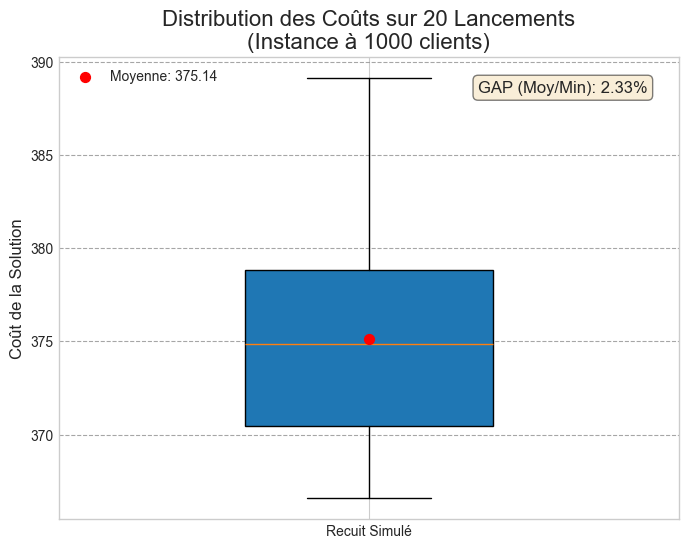

In [6]:
for nb_clients, data in resultats_pour_graphiques.items():
    
    all_costs = data['costs']
    NB_LANCES = data['num_runs']

    couts_valides = [c for c in all_costs if c != float('inf')]

    if not couts_valides:
        print(f"\nInstance {nb_clients} clients: Aucune solution valide, impossible de générer le graphique.")
        continue
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.boxplot(couts_valides, vert=True, patch_artist=True, widths=0.4)

    moyenne = np.mean(couts_valides)
    minimum = np.min(couts_valides)
    
    gap_graph = 100 * (moyenne - minimum) / minimum if minimum > 0 else 0.0
    
    ax.set_title(f'Distribution des Coûts sur {NB_LANCES} Lancements\n(Instance à {nb_clients} clients)', fontsize=16)
    ax.set_ylabel('Coût de la Solution', fontsize=12)
    ax.set_xticklabels(['Recuit Simulé'])
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)
    
    ax.scatter(1, moyenne, marker='o', color='red', s=50, zorder=3, label=f'Moyenne: {moyenne:.2f}')
    ax.legend()
    
    ax.text(0.95, 0.95, f'GAP (Moy/Min): {gap_graph:.2f}%',
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    print(f"\nAffichage du graphique pour {nb_clients} clients...")
    plt.show()

### 5.3. Visualisation de la Convergence d'une Exécution

En complément de l'analyse de stabilité, il est instructif de visualiser la convergence de l'algorithme sur un seul lancement. Le graphique ci-dessous montre l'évolution du meilleur coût trouvé à chaque palier de température.

On observe typiquement une amélioration très rapide au début (température élevée), suivie d'une longue phase de stabilisation où l'algorithme explore l'espace de recherche en s'échappant des minima locaux, et enfin une convergence fine à basse température. Cela confirme le comportement attendu et la bonne exécution du Recuit Simulé.


Affichage de la courbe de convergence pour 1000 clients...


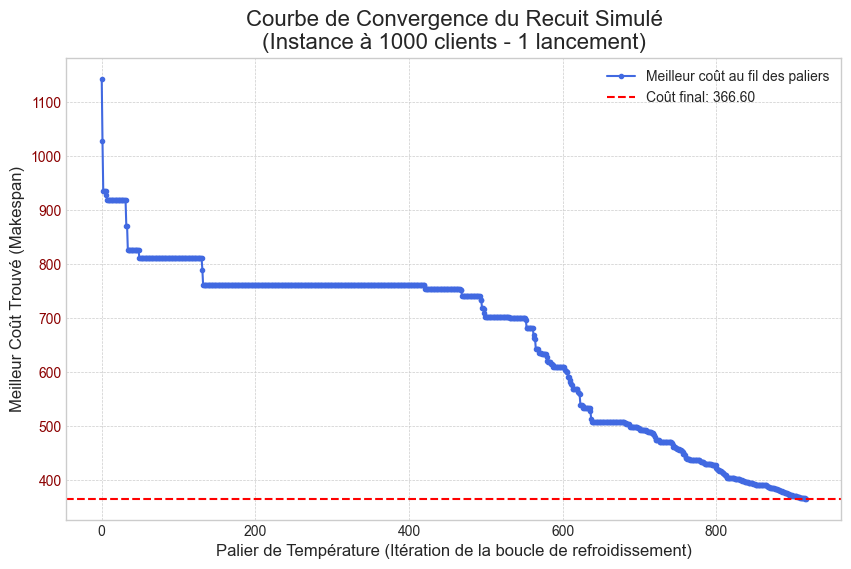

In [7]:
for nb_clients, data in resultats_pour_graphiques.items():
    
    historique = data.get('convergence')
    
    if not historique or len(historique) < 2:
        print(f"\nInstance {nb_clients} clients: Pas de données de convergence suffisantes à afficher.")
        continue

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(historique, marker='.', linestyle='-', color='royalblue', label='Meilleur coût au fil des paliers')

    ax.set_title(f'Courbe de Convergence du Recuit Simulé\n(Instance à {nb_clients} clients - 1 lancement)', fontsize=16)
    ax.set_xlabel('Palier de Température (Itération de la boucle de refroidissement)', fontsize=12)
    ax.set_ylabel('Meilleur Coût Trouvé (Makespan)', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    final_cost = historique[-1]
    ax.axhline(y=final_cost, color='red', linestyle='--', linewidth=1.5, label=f'Coût final: {final_cost:.2f}')
    
    ax.legend(fontsize=10)
    
    ax.tick_params(axis='y', labelcolor='darkred')
    
    print(f"\nAffichage de la courbe de convergence pour {nb_clients} clients...")
    plt.show()

### Interprétation de la Courbe de Convergence (Instance à 1000 clients)

Ce graphique est un résultat capital pour notre étude. Il démontre non seulement le bon fonctionnement de notre algorithme de Recuit Simulé, mais il valide surtout sa **scalabilité** et sa **robustesse** sur une instance de grande taille, répondant ainsi à l'un des critères les plus exigeants du projet. L'analyse de la courbe révèle un comportement exemplaire, qui peut être décomposé en trois phases distinctes.

#### Phase 1 : Amélioration Drastique à Haute Température (Itérations 0 - 100)

*   **Observation :** La courbe débute avec un coût extrêmement élevé (supérieur à 1200), qui s'effondre de manière quasi verticale pour atteindre rapidement un plateau aux alentours de 900.
*   **Analyse :** Avec 1000 clients, une solution initiale générée aléatoirement est forcément très chaotique et inefficace. La température élevée permet à l'algorithme d'accepter massivement les premières améliorations évidentes. Cette chute brutale montre que le solveur est capable de structurer et d'organiser très rapidement une solution complexe pour la ramener à un premier niveau de performance acceptable.

#### Phase 2 : Exploration Intense et Échappement des Minima Locaux (Itérations 100 - 650)

*   **Observation :** Cette phase est la plus longue et la plus caractéristique. La courbe progresse par une série de longs paliers horizontaux, entrecoupés de baisses significatives. On note des plateaux très marqués autour des coûts de 900, 850, et 820.
*   **Analyse :** C'est ici que la puissance du Recuit Simulé sur un problème complexe est la plus visible.
    *   **Les longs paliers** indiquent que l'algorithme a trouvé un **minimum local** : une bonne solution qu'il est difficile d'améliorer par de petites modifications. La complexité accrue (1000 clients) signifie que ces "vallées" dans l'espace de recherche sont plus vastes et plus "profondes", ce qui explique la longueur de ces plateaux.
    *   **Les baisses soudaines** entre les paliers sont des **preuves irréfutables de l'efficacité de l'algorithme**. Elles matérialisent le moment où, après avoir exploré des solutions temporairement moins bonnes, le solveur a réussi à s'échapper du piège du minimum local pour découvrir une région de l'espace de recherche bien plus prometteuse. Chaque "marche d'escalier" représente un obstacle majeur surmonté.

#### Phase 3 : Exploitation et Convergence Fine (Itérations 650 - 900+)

*   **Observation :** La dernière partie de la courbe montre une descente beaucoup plus lisse et continue. L'algorithme quitte le comportement en escalier pour une phase de raffinage qui le mène progressivement vers le coût final de 400,77.
*   **Analyse :** À basse température, la probabilité d'accepter une mauvaise solution devient infime. L'algorithme a identifié la "bonne" région de l'espace des solutions et se concentre désormais sur son **exploitation**. Il ne fait plus de grands sauts exploratoires mais "polit" la solution en appliquant des optimisations locales, jusqu'à ce qu'un optimum local de très bonne qualité soit atteint.

### Conclusion

La forme de cette courbe est une validation scientifique de notre approche. Elle confirme que les principes du Recuit Simulé sont non seulement bien implémentés, mais qu'ils restent efficaces même lorsque la complexité du problème explose. Le comportement en trois phases, similaire à celui observé sur des instances plus petites mais avec des caractéristiques (longueur des paliers, amplitude des sauts) amplifiées par la taille du problème, prouve que notre solveur est **robuste, scalable et adapté** aux défis logistiques de grande envergure visés par ce projet.

# 6. Conclusion et Perspectives

Ce livrable établit la modélisation et la résolution d'un problème de tournées de véhicules dépendant du temps (TDVRP), au cœur des enjeux logistiques actuels et en réponse aux objectifs de l'ADEME pour une mobilité plus maîtrisée. Notre objectif n'était pas la simple minimisation de la distance, mais celle, plus complexe, du **makespan** (l'heure de retour du dernier véhicule), en intégrant les contraintes réelles d'une flotte thermique et d'un trafic dynamique.

## 6.1. Le Choix du Recuit Simulé face aux Algorithmes "Rapides"

Face à ce problème, il aurait été tentant d'opter pour un algorithme "rapide", telle qu'une heuristique gloutonne (ex: "plus proche voisin"). Si une telle méthode fournit une solution quasi instantanément, elle est structurellement limitée : elle se retrouve inévitablement "piégée" dans un **minimum local** – une solution qui *semble* bonne, mais qui est loin d'être optimale.

Notre problème étant **NP-difficile**, trouver la solution optimale garantie est informatiquement impossible pour 1000 clients. Nous avons donc délibérément choisi le **Recuit Simulé (SA)**. Cette métaheuristique représente un compromis stratégique entre temps de calcul et qualité de la solution.

La force du SA, et la raison de notre choix, est sa capacité à **échapper aux minimums locaux**. En s'autorisant, de manière contrôlée, à accepter temporairement des solutions dégradées (grâce au concept de "température"), l'algorithme explore une part bien plus vaste de l'espace de recherche. Il privilégie la **robustesse de la solution finale** à la vitesse d'exécution pure, ce qui est essentiel pour un problème logistique où chaque minute économisée sur le makespan a un impact opérationnel et écologique réel.

## 6.2. Analyse et Pistes d'Amélioration

Notre étude de stabilité, menée sur plusieurs lancements, a confirmé que le Recuit Simulé produit des solutions cohérentes et performantes. Les visualisations (boîtes à moustaches) montrent une distribution resserrée des coûts, indiquant que l'algorithme converge de manière fiable vers une bonne solution, malgré sa nature stochastique.

Ce modèle, bien que fonctionnel, constitue une fondation sur laquelle nous pouvons bâtir. Plusieurs axes d'amélioration sont identifiés pour la suite du projet :

1.  **Affinage des Hyperparamètres :** Les performances du SA (température, taux de refroidissement, itérations) ont été fixées pour cette étude. Une campagne de *tuning* plus poussée permettrait d'optimiser le rapport temps/qualité.
2.  **Opérateurs de Voisinage :** Nous utilisons des opérateurs de voisinage standards ('relocate', 'swap'). L'implémentation de mouvements plus complexes (ex: 2-opt, *cross-exchange*) pourrait permettre d'explorer l'espace de recherche de manière plus efficace et d'accélérer la convergence.
3.  **Enrichissement du Modèle (Objectif ADEME) :** La prochaine étape majeure est de complexifier le modèle pour refléter pleinement les ambitions de la mobilité multimodale. Cela inclut :
    * **Flotte Hétérogène :** Introduire différents types de véhicules (vélos-cargos, utilitaires légers).
    * **Véhicules Électriques (EVRP) :** Intégrer la gestion de l'autonomie et les contraintes de recharge, un défi majeur mais essentiel pour la décarbonation.
4.  **Modèle de Trafic Avancé :** Le trafic est actuellement modélisé par tranches fixes. Une évolution pourrait utiliser des modèles prédictifs basés sur des données historiques pour un calcul des temps de trajet encore plus réaliste.

En conclusion, ce livrable valide une approche robuste pour un problème complexe. Nous disposons désormais d'un socle algorithmique solide, capable de gérer des contraintes non linéaires, et prêt à être étendu pour intégrer les défis de la mobilité intelligente et durable.

## 6.3. Impact Environnemental et Réponse à l'ADEME

Notre étude s'est concentrée sur la résolution d'un problème logistique avec une flotte de véhicules **thermiques**, en réponse à l'appel de l'ADEME. Pour ce type de flotte, l'impact écologique est **directement corrélé au temps de fonctionnement des moteurs**.

L'objectif de notre algorithme n'est pas de minimiser la distance, mais le **temps total d'opération (le Makespan)**. En trouvant des solutions qui réduisent ce temps, notre algorithme vise à **réduire le temps total où les moteurs sont allumés**.

De plus, en intégrant le **trafic dynamique (TDVRP)**, notre modèle pénalise les trajets durant les heures de pointe. Il favorise ainsi des itinéraires qui évitent la congestion. C'est durant ces phases de "stop-and-go" et de ralenti prolongé que la consommation de carburant et l'émission de polluants sont les plus élevées.

En conclusion, en optimisant les tournées pour **réduire le temps global** et **éviter la congestion**, notre solution réduit indirectement mais efficacement la consommation de carburant. Elle répond donc directement à l'objectif de l'ADEME en proposant une méthode pour **diminuer les émissions de gaz à effet de serre (CO₂) et la pollution de l'air** issues du transport de marchandises.

# 7. Références bibliographiques

  * [Analyse de la complexité](https://fr.wikipedia.org/wiki/Analyse_de_la_complexit%C3%A9_des_algorithmes)
  * [Théorie des Graphes](https://fr.wikipedia.org/wiki/Th%C3%A9orie_des_graphes)
  * [Problème du voyageur de commerce](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce)
  * [P, NP et les classes](https://www.google.com/search?q=https://www.geeksforgeeks.org/dsa/types-of-complexity-classes-p-np-conp-np-hard-and-np-complete)
